In [38]:
import numpy as np
import torch
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as L
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
bank_marketing = fetch_ucirepo(id=222)

X = pd.DataFrame(bank_marketing.data.features)
y = pd.DataFrame(bank_marketing.data.targets)

y = y['y'].map({'yes': 1, 'no': 0})

X = X.drop('duration', axis=1)

binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    X[col] = X[col].map({'yes': 1, 'no': 0})

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
X['month_num'] = X['month'].map(month_map)

X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)

X = X.drop(['month', 'month_num'], axis=1)

if 'day' in X.columns:
    X['day_sin'] = np.sin(2 * np.pi * X['day'] / 31)
    X['day_cos'] = np.cos(2 * np.pi * X['day'] / 31)
    X = X.drop('day', axis=1)

X['was_contacted'] = (X['pdays'] != -1).astype(int)

X['pdays'] = X['pdays'].replace(-1, 0)

X['contact'] = X['contact'].fillna('unknown')

X['poutcome'] = X['poutcome'].fillna('other')

X = pd.get_dummies(X, columns=['job'], drop_first=True)
X = pd.get_dummies(X, columns=['marital'], drop_first=True)
X = pd.get_dummies(X, columns=['education'], drop_first=True)
X = pd.get_dummies(X, columns=['contact'], drop_first=True)
X = pd.get_dummies(X, columns=['poutcome'], drop_first=True)

int_columns = X.select_dtypes(include=['int64']).columns
X[int_columns] = X[int_columns].astype(float)

bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=60224,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=60224, stratify=y_train_full)

cols_to_scale = ['age', 'balance', 'campaign', 'previous', 'pdays']

cols_to_scale = [c for c in cols_to_scale if c in X_train.columns]

scaler = RobustScaler()

scaler.fit(X_train[cols_to_scale])

X_train.loc[:, cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val.loc[:, cols_to_scale]   = scaler.transform(X_val[cols_to_scale])
X_test.loc[:, cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

X_train = X_train.values.astype(np.float32)
X_val   = X_val.values.astype(np.float32)
X_test  = X_test.values.astype(np.float32)

y_train = y_train.values.reshape(-1, 1).astype(np.float32)
y_val   = y_val.values.reshape(-1, 1).astype(np.float32)
y_test  = y_test.values.reshape(-1, 1).astype(np.float32)


In [3]:
print(X_train.shape)

(31665, 30)


## Wyzwanie

Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).


## Jak zrobić zadanie

0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:

- [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
- [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
- [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
- [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
- [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
- [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. _chory ∈ {true, false}_, _kolor ∈ {zielony, niebieski, czerwony}_), lub jaka jest wartość pewnej cechy (np. _temperatura ∈ ℜ_, _punkty z egzaminu_ ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.


## 1. Perceptron\*

Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie

- σ to funkcja aktywacji
- $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
- 𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
- b to skalar, zwany _biasem_ (wyuczalny parametr)
- $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:

- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, _co oznacza wyjście sieci_, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

\*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.


### ⚡ Zaimplementuj tutaj perceptron


In [4]:
class Perceptron:

  def __init__(self, input_size):
    self.W = np.random.randn(input_size, 1) * 0.01
    self.b = 0.0 
    pass

  def forward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    z = X @ self.W + self.b
    output = 1 / (1 + np.exp(-z))
    return output

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:

1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:

- Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
- Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
- Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$L = \frac{1}{M} g(A, Gt)$ -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)

$\frac{∂L}{∂𝑤} = ? $ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)

$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
Decyduje ona o szybkości treningu.

Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję _train_, a w środku ma zachodzić cała magia. Funkcja _predict_ ma służyć do predykcji kategorii dla próbek testowych.


In [8]:
class Trainer:

  def __init__(self, perceptron: Perceptron, optimizer, n_epochs: int, batch_size: int,learning_rate):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
    
  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    bce = -np.mean(y*np.log(A+1e-8)+ (1-y)*np.log(1-A+1e-8))
    return bce

  def backward(self, X: np.ndarray, A: np.array, Y: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    m = X.shape[0]

    dW = (X.T @ (A-Y)) / m
    db = np.sum(A-Y) / m
    return dW, db

  def update_weights(self, dW, db): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    self.perceptron.W = self.perceptron.W - self.learning_rate * dW
    self.perceptron.b = self.perceptron.b - self.learning_rate * db

    #wywaloanie Adam optimizera 
    # self.optimizer.update(self.perceptron, dW, db)
    return None

  #podstawowy training loop bez podzialu caly dataset na raz
  # def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    
  #   for i in range(self.n_epochs):
  #     A = self.perceptron.forward
  #     curren_los = self.loss(A, y)
  #     dW, db = self.backward(X, A, y)
  #     self.update_weights(dW, db)
  #     if i % 100 == 0:
  #       print(f"epoka {i}, loss: {curren_los:.4f}")

  #   return None

  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    
    tensor_x = torch.tensor(X_train, dtype=torch.float32)
    tensor_y = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(tensor_x, tensor_y)
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    for epoch in range(self.n_epochs):

      for X_batch_tensor, y_batch_tensor in loader:

        X_batch = X_batch_tensor.numpy()
        y_batch = y_batch_tensor.numpy()

        A = self.perceptron.forward(X_batch)
        dW, db = self.backward(X_batch, A, y_batch)
        self.update_weights(dW, db)
      
      train_out_probs = self.perceptron.forward(X_train)
      loss_t = self.loss(train_out_probs, y_train)
      preds_t = self.predict(X_train)
      acc_t = np.mean(preds_t == y_train)
            
      val_out_probs = self.perceptron.forward(X_val)
      loss_v = self.loss(val_out_probs, y_val)
      preds_v = self.predict(X_val)
      acc_v = np.mean(preds_v == y_val)
            
      self.history['train_loss'].append(loss_t)
      self.history['val_loss'].append(loss_v)
      self.history['train_acc'].append(acc_t)
      self.history['val_acc'].append(acc_v)
      
    self.plot_metrics() 

  
  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X)
    predictions = np.where(A > 0.5, 1, 0)
    return predictions
  
  def plot_metrics(self):
    epochs = range(len(self.history['train_loss']))
        
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, self.history['train_loss'], label='train')
    plt.plot(epochs, self.history['val_loss'], label='val', linestyle='--')
    plt.title('Loss')
    plt.xlabel('epoka')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, self.history['train_acc'], label='trening')
    plt.plot(epochs, self.history['val_acc'], label=('val'), linestyle='--')
    plt.title('accuracy')
    plt.xlabel('epoka')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

## HINTS

Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy `np.dot` lub `@`.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)


### Uczenie paczkami

Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:

- batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
- stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
- mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji _train_ ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Coś stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy _Trainer_ funkcji, które zapiszą, na końcu każdej epoki

(a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".


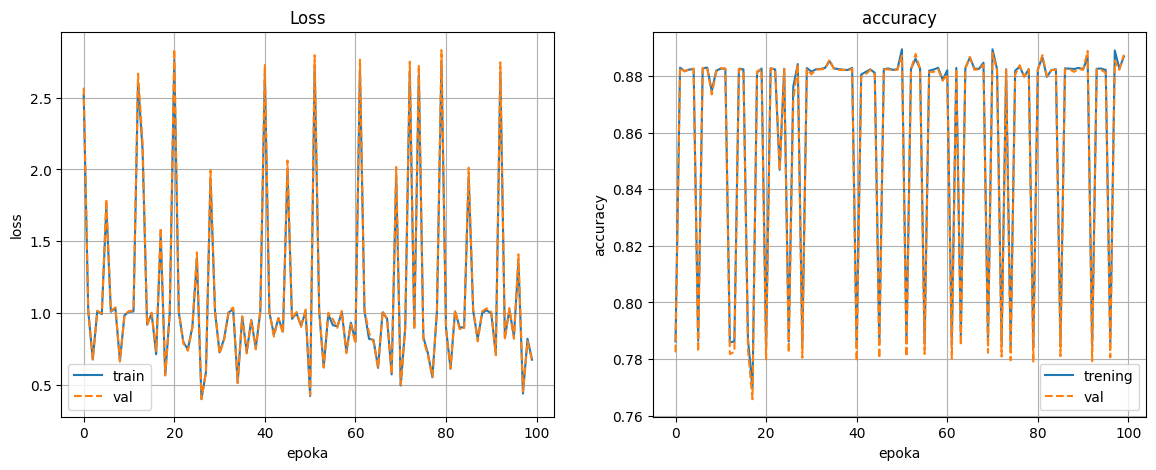

In [10]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None, 
    n_epochs=100,
    learning_rate=0.01,
    batch_size=32
)

trainer.train(X_train, y_train, X_val, y_val)


Model zamiast schodzic w dół skacze wokół minimum zbyt wysoki learning rate, za malo epok 

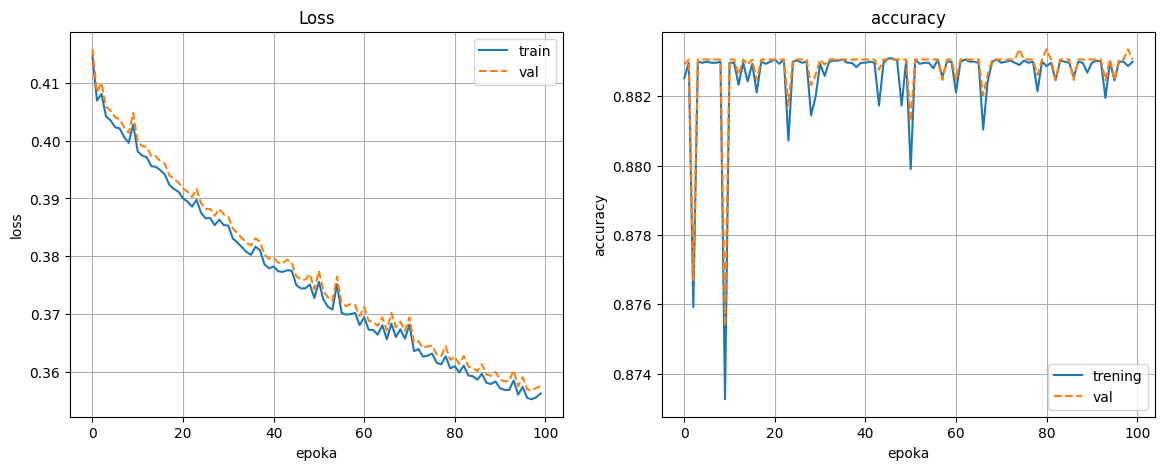

In [11]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None, 
    n_epochs=100,
    learning_rate=0.0001,
    batch_size=64
)

trainer.train(X_train, y_train, X_val, y_val)


model zaczyna schodzic w dol ale za mala ilość epok uniemozliwia mu pelne wyuczenie 

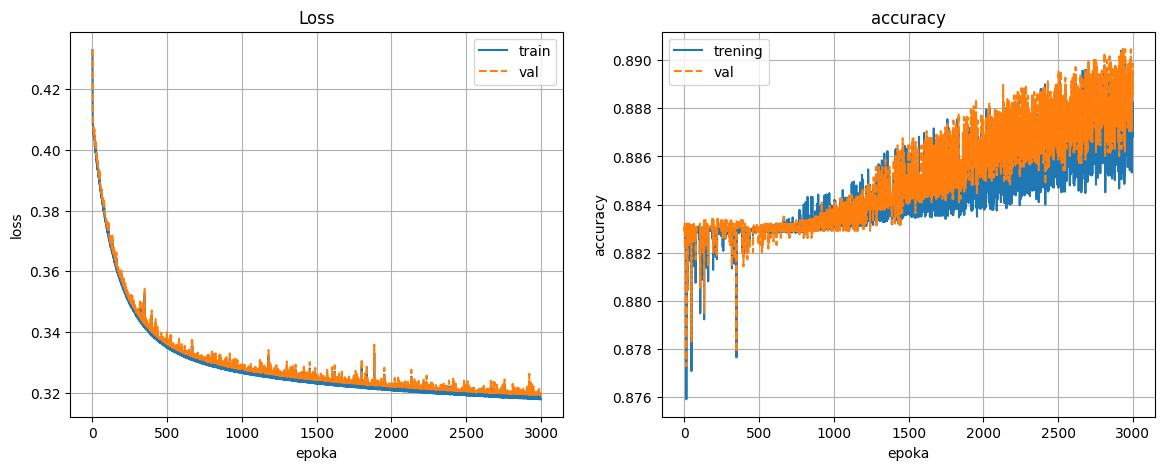

In [12]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None,
    n_epochs=3000,
    learning_rate=0.0001,
    batch_size=128
)

trainer.train(X_train, y_train, X_val, y_val)


Model zaczal sie uczyc acc zaczelo rosnąć, ale nie jest to w pelni wyuczony model

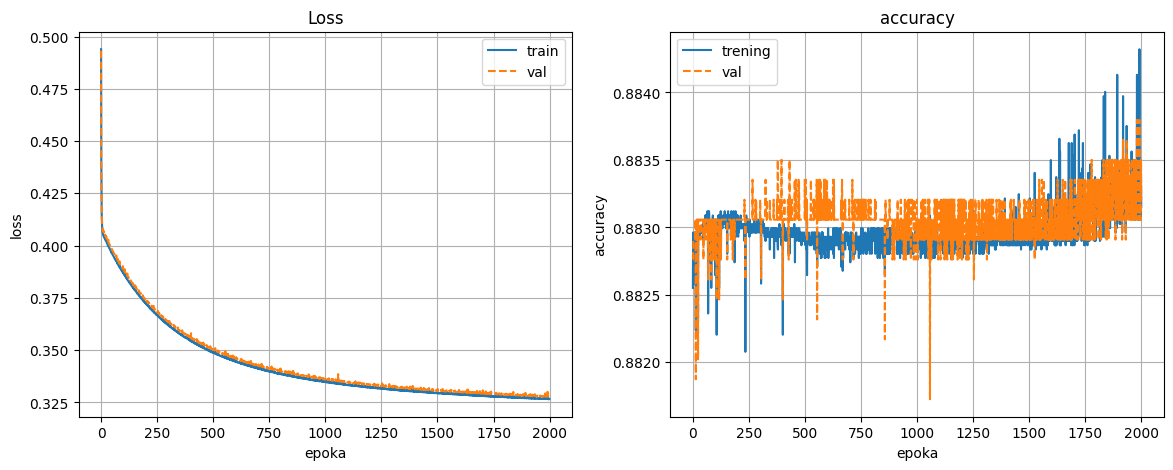

In [14]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None,
    n_epochs=2000,
    learning_rate=0.0001,
    batch_size=256
)

trainer.train(X_train, y_train, X_val, y_val)


dalsze powiekszania batcha nie wplywa na wyniki modelu, wrecz wprowadza coraz to wiekszy szum

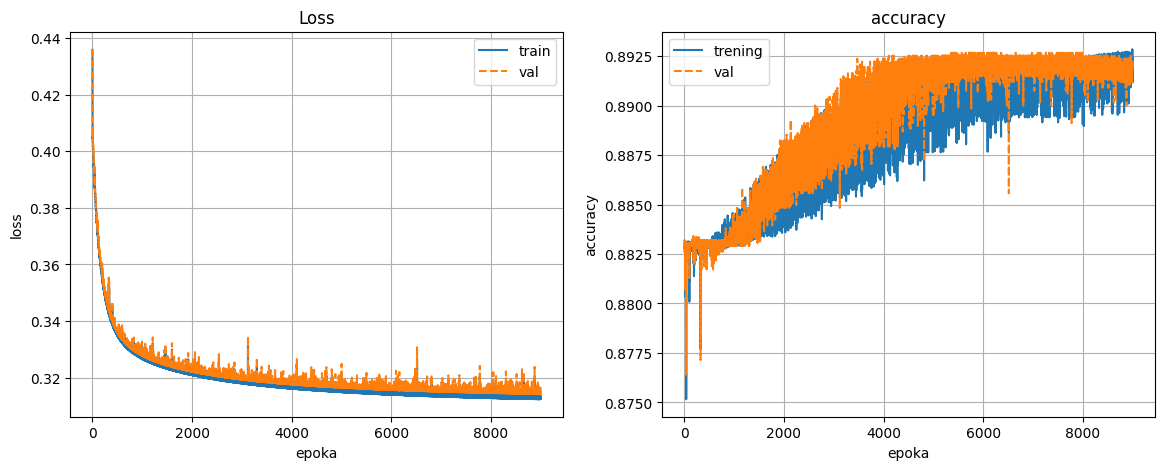

In [15]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None, 
    n_epochs=9000,
    learning_rate=0.0001,
    batch_size=128
)

trainer.train(X_train, y_train, X_val, y_val)


jako iz model posiada tylko 1 warstwe widać ewidentą zmbierzność do pewnej granicy w danych jaką model osiąga, nie jest on jednak przeuczony 

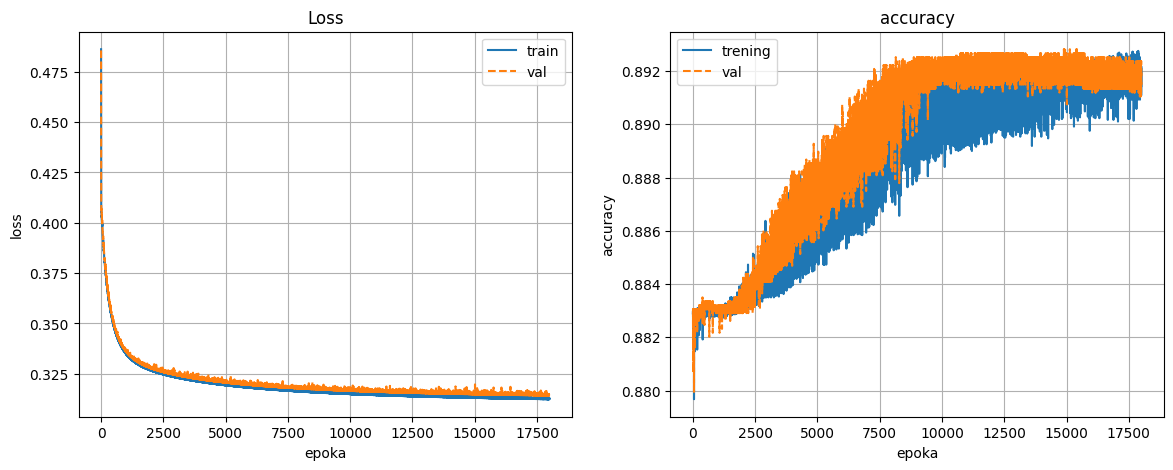

In [16]:
model = Perceptron(input_size=30)

trainer = Trainer(
    perceptron=model,
    optimizer=None,
    n_epochs=18000,
    learning_rate=0.00005,
    batch_size=128
)

trainer.train(X_train, y_train, X_val, y_val)


nigdzie nie doszlo do przeuczenia, gdyby do takiego doszlo treining acc był by widocznie lepszy od zbioru validacyjnego


nasz model skladajacy sie z az 1 neuronu jest zbyt dobry (po prostu sieć jest zbut plytka i nie wystarcza)


najlepsze wyniki dla
n_epochs=3000,
learning_rate=0.0001,
batch_size=128
<br>
model uzyskał najlepsze wyniki dla podanych parametrow acc faktycznie rosnie nie ma overfitingu. Dla innych parametrow szczegolnie wykres 1.
<br>
perceptron=model,
n_epochs=100,
learning_rate=0.01,
batch_size=32
<br>
model mial ustawiony zbyt wysoki learning rate co mozna zauwazyc przez skaczacy nie malejaca loss oraz acc z losowymi zianami


### ⭐ Ekstra zadanie - optymizator

Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu _Momentum_ czy _Adagrad_ (choć w praktyce zwykle _Adam_). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).


In [17]:
class Trainer:

  def __init__(self, perceptron: Perceptron, optimizer, n_epochs: int, batch_size: int):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
    
  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    bce = -np.mean(y*np.log(A+1e-8)+ (1-y)*np.log(1-A+1e-8))
    return bce

  def backward(self, X: np.ndarray, A: np.array, Y: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    m = X.shape[0]

    dW = (X.T @ (A-Y)) / m
    db = np.sum(A-Y) / m
    return dW, db

  def update_weights(self, dW, db): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    #wywaloanie Adam optimizera 
    self.optimizer.update(self.perceptron, dW, db)
    return None



  def train(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    
    tensor_x = torch.tensor(X_train, dtype=torch.float32)
    tensor_y = torch.tensor(y_train, dtype=torch.float32)
    dataset = TensorDataset(tensor_x, tensor_y)
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    for epoch in range(self.n_epochs):

      for X_batch_tensor, y_batch_tensor in loader:

        X_batch = X_batch_tensor.numpy()
        y_batch = y_batch_tensor.numpy()

        A = self.perceptron.forward(X_batch)
        dW, db = self.backward(X_batch, A, y_batch)
        self.update_weights(dW, db)
      
      train_out_probs = self.perceptron.forward(X_train)
      loss_t = self.loss(train_out_probs, y_train)
      preds_t = self.predict(X_train)
      acc_t = np.mean(preds_t == y_train)
            
      val_out_probs = self.perceptron.forward(X_val)
      loss_v = self.loss(val_out_probs, y_val)
      preds_v = self.predict(X_val)
      acc_v = np.mean(preds_v == y_val)
            
      self.history['train_loss'].append(loss_t)
      self.history['val_loss'].append(loss_v)
      self.history['train_acc'].append(acc_t)
      self.history['val_acc'].append(acc_v)
      
    self.plot_metrics() 

  
  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    A = self.perceptron.forward(X)
    predictions = np.where(A > 0.5, 1, 0)
    return predictions
  
  def plot_metrics(self):
    epochs = range(len(self.history['train_loss']))
        
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, self.history['train_loss'], label='train')
    plt.plot(epochs, self.history['val_loss'], label='val', linestyle='--')
    plt.title('Loss')
    plt.xlabel('epoka')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, self.history['train_acc'], label='trening')
    plt.plot(epochs, self.history['val_acc'], label=('val'), linestyle='--')
    plt.title('accuracy')
    plt.xlabel('epoka')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

In [18]:
class Adam:
    def __init__(self, learning_rate, beta1, beta2, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = learning_rate
        self.epsilon = epsilon
        self.t = 0

        self.mW = None
        self.vW = None
        self.mb = None
        self.vb = None
        pass
    def update(self, perceptron, dW, db):
        if self.mW is None:
            self.mW = np.zeros_like(perceptron.W)
            self.vW = np.zeros_like(perceptron.W)
            self.mb = 0.0
            self.vb = 0.0

        self.t += 1
        
        self.mW = self.beta1 * self.mW + (1 - self.beta1) * dW
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db

        self.vW = self.beta2 * self.vW + (1 - self.beta2) * (dW**2)
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db**2)

        mW_hat = self.mW / (1 - self.beta1 ** self.t)
        mb_hat = self.mb / (1 - self.beta1 ** self.t)
        
        vW_hat = self.vW / (1 - self.beta2 ** self.t)
        vb_hat = self.vb / (1 - self.beta2 ** self.t)

        perceptron.W -= self.lr * mW_hat / (np.sqrt(vW_hat) + self.epsilon)
        perceptron.b -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.epsilon)

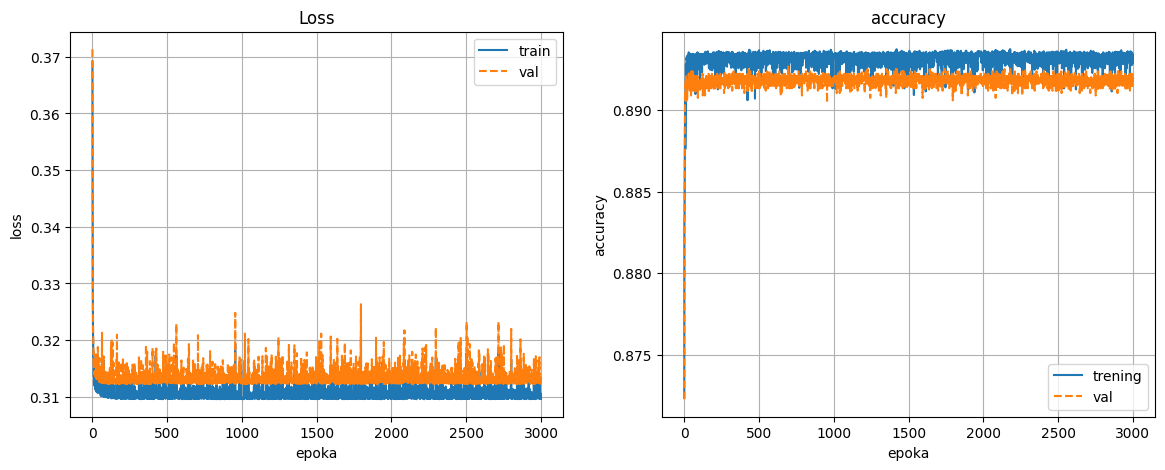

In [19]:
model = Perceptron(input_size=30)
adam_optimizer = Adam(
    learning_rate = 0.001,
    beta1= 0.9,
    beta2= 0.999
)
trainer = Trainer(
    perceptron = model,
    optimizer = adam_optimizer,
    n_epochs = 3000,
    batch_size = 128
)

trainer.train(X_train, y_train, X_val, y_val)


Szumy świadczą o tym ze model nie moze zatrzymac sie na dnie, jest to klasyczny problem optymalizatora Adam, nie powiedziałbym ze wystapiło tutaj przeuczenie gdyz linie sa stosunkowo zbierzne. Probelm lezy w stalym learning rate 

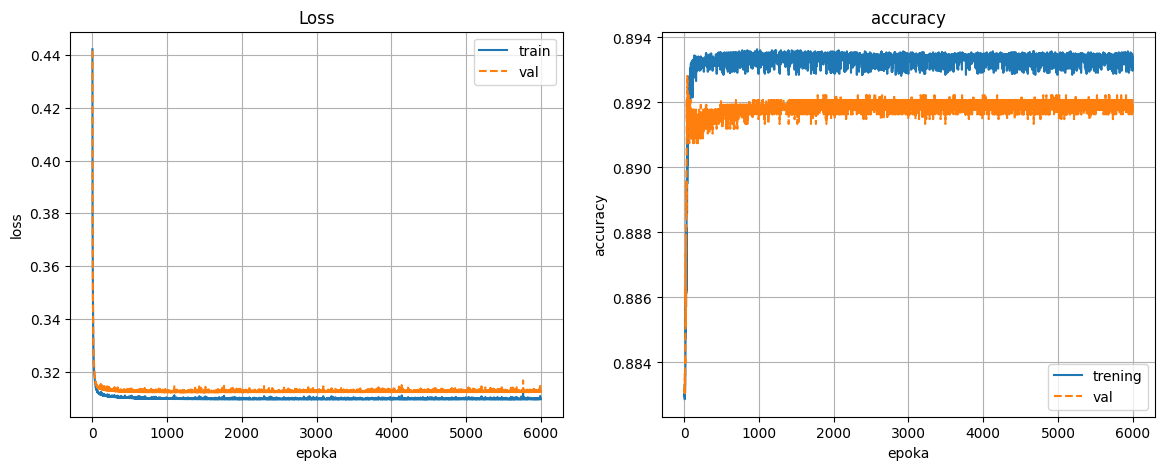

In [20]:
model = Perceptron(input_size=30)
adam_optimizer = Adam(
    learning_rate = 0.0001,
    beta1= 0.9,
    beta2= 0.999
)
trainer = Trainer(
    perceptron = model,
    optimizer = adam_optimizer,
    n_epochs = 6000,
    # learning_rate = 0.0001,
    batch_size = 64
)

trainer.train(X_train, y_train, X_val, y_val)


### ⚡ Eksperymenty

Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.


to w sumie wyrzej zrobiłem

## 2. Implementacja sieci w pytorchu

Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.


### Tensory

Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.


In [21]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu

Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.

---

_Uwaga_: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

_Uwaga do uwagi_: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.


In [22]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [23]:
class Perceptron_pytorch(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        z = self.linear(x)
        output = torch.sigmoid(z)
        
        return output

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, shape):
            super(NeuralNetwork, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(shape, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.3),
                
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),
                
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

    def forward(self, x):
        return self.network(x)

### Lignthing module 

In [31]:
class LightningNN(L.LightningModule):
    def __init__(self, learning_rate=0.0001, hidden_size=128, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()
        self.neural_network = nn.Sequential(
            nn.Linear(30, self.hparams.hidden_size),
            nn.BatchNorm1d(self.hparams.hidden_size),
            nn.ReLU(),
            nn.Dropout(self.hparams.dropout),
            
            nn.Linear(self.hparams.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
        )
        self.criterion = nn.BCEWithLogitsLoss()
        
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()
        self.val_f1 = BinaryF1Score()
        self.val_auc = BinaryAUROC()

    def forward(self, x):
        return self.neural_network(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-5)
        # zmina opimiezera jezeli loss nie spada prze 5 cykli 
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/val_loss"
            }
        }
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        preds = torch.sigmoid(logits)
        self.train_acc(preds, y)


        self.log('train/train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train/train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        preds = torch.sigmoid(logits)
        
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_auc(preds, y)
        
        self.log('val/val_loss', loss, prog_bar=True)
        self.log('val/val_acc', self.val_acc, prog_bar=True)
        self.log('val/val_f1', self.val_f1, prog_bar=True)
        self.log('val/val_auc', self.val_auc, prog_bar=True)
        return 

In [ ]:
L.seed_everything(67) #seed o ktorym zapomialem w wczesniejeszych treningach 

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

logger = TensorBoardLogger(
    "tb_logs", 
    name="first_run",
    default_hp_metric=False
)

model = LightningNN(
    learning_rate=0.001,
    hidden_size=64,
    dropout=0.3
)

logger = TensorBoardLogger("tb_logs", name="first_run")

early_stop = EarlyStopping(monitor="val/val_loss", patience=15, mode="min")
checkpoint = ModelCheckpoint(monitor="val/val_acc", mode="max", save_top_k=1)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(
    max_epochs=100,
    logger=logger,
    accelerator="auto",
    callbacks=[early_stop, checkpoint, lr_monitor]
)

trainer.fit(model, train_loader, val_loader)

Seed set to 67
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name           | Type              | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | neural_network | Sequential        | 8.6 K  | train | 0    
1 | criterion      | BCEWithLogitsLoss | 0      | train | 0    
2 | train_acc      | BinaryAccuracy    | 0      | train | 0    
3 | val_acc        | BinaryAccuracy    | 0      | train | 0    
4 | val_f1         | BinaryF1Score     | 0      | train | 0    
5 | val_auc        | BinaryAUROC       | 0      | train | 0    
---------------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 80: 100%|██████████| 248/248 [00:02<00:00, 114.75it/s, v_num=0, val/val_loss=0.296, val/val_acc=0.889, val/val_f1=0.314, val/val_auc=0.785, train/train_loss=0.286, train/train_acc=0.896]


In [35]:
model = LightningNN(
    learning_rate=0.0001,
    hidden_size=128,
    dropout=0.2
)

logger = TensorBoardLogger("tb_logs", name="first_run")

early_stop = EarlyStopping(monitor="val/val_loss", patience=15, mode="min")
checkpoint = ModelCheckpoint(monitor="val/val_acc", mode="max", save_top_k=1)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(
    max_epochs=200,
    logger=logger,
    accelerator="auto",
    callbacks=[early_stop, checkpoint, lr_monitor]
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name           | Type              | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | neural_network | Sequential        | 14.8 K | train | 0    
1 | criterion      | BCEWithLogitsLoss | 0      | train | 0    
2 | train_acc      | BinaryAccuracy    | 0      | train | 0    
3 | val_acc        | BinaryAccuracy    | 0      | train | 0    
4 | val_f1         | BinaryF1Score     | 0      | train | 0    
5 | val_auc        | BinaryAUROC       | 0      | train | 0    
---------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 97: 100%|██████████| 248/248 [00:02<00:00, 102.68it/s, v_num=1, val/val_loss=0.300, val/val_acc=0.889, val/val_f1=0.329, val/val_auc=0.776, train/train_loss=0.296, train/train_acc=0.893] 


Nie da rady wyciągnąć więcej niz 90 % acc 

acc na tesowym: 0.89
Raport klasyfikacji:
              precision    recall  f1-score   support

       nie 0       0.90      0.98      0.94      5989
       tak 1       0.58      0.19      0.28       793

    accuracy                           0.89      6782
   macro avg       0.74      0.58      0.61      6782
weighted avg       0.86      0.89      0.86      6782



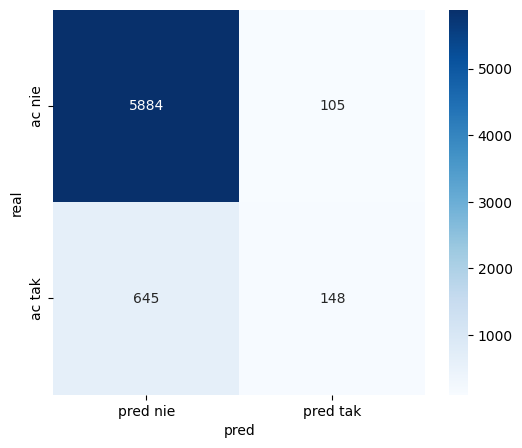

In [48]:
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

best_model_path = checkpoint.best_model_path
best_model = LightningNN.load_from_checkpoint(best_model_path)

best_model.to("cpu")
best_model.eval()
best_model.freeze()

X_test_t = X_test_t.to("cpu")

with torch.no_grad():
    logits = best_model(X_test_t)

    probs = torch.sigmoid(logits)
    
    preds = (probs > 0.5).float()


y_true = y_test_t.numpy()
y_pred = preds.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
print(f"acc na tesowym: {acc:.2f}")

print("Raport klasyfikacji:")
print(classification_report(y_true, y_pred, target_names=['nie 0', 'tak 1']))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pred nie', 'pred tak'], yticklabels=['ac nie', 'ac tak'])
plt.ylabel('real')
plt.xlabel('pred')
plt.show()

dane nie nadaja sie do ternowania modelu zbyt duza jest przewaga danych z y = nie, nad tymiz z tak. Model osiaga fatalne wyniki poniewaz f1 score dla tak wynosi tylko 0.28. Moze byc to spowodowane tym ze znowu źle zrobiłem EDA danych lub po prostu tak ma być. Mimo próby szczelania "armatą do muchy" z tak rozbudowana siecia nie jestesmy w stanie osiagnac lepszych wynikow i praktycznie kazde sa zbiezne do 90 % acc, oraz bardzo slabego f1 scora dla kategori tak 

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?

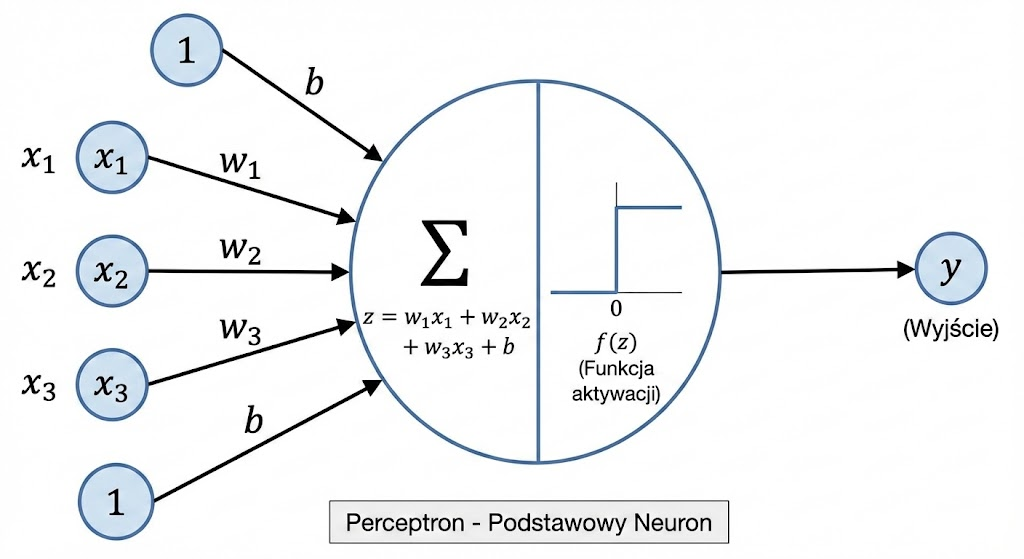


No trochę b za duzo
